# Image Classification: Manhattan (L1) vs Euclidean (L2) Distances


## 1. Setup and Data Loading


In [1]:
!gdown 12TaqtK7CgnSpFnMmxSv4m5fHrFtZA_z0 -O animal_dataset.zip

!unzip -q -o animal_dataset.zip

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline

Downloading...
From: https://drive.google.com/uc?id=12TaqtK7CgnSpFnMmxSv4m5fHrFtZA_z0
To: /content/animal_dataset.zip
100% 20.6M/20.6M [00:00<00:00, 36.3MB/s]


In [2]:
def load_data_with_pandas(data_dir):

    classes = ['cat', 'dog', 'panda']
    data_list = []

    print("Scanning files...")

    for label, class_name in enumerate(classes):
        path = os.path.join(data_dir, class_name)
        if not os.path.exists(path):
            print(f"Warning: {path} not found!")
            continue

        for file in os.listdir(path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data_list.append({
                    'filepath': os.path.join(path, file),
                    'label': label,
                    'class_name': class_name
                })

    df = pd.DataFrame(data_list)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Found {len(df)} images. Loading and preprocessing...")

    X = []
    y = []

    # 4. Load images from the shuffled DataFrame
    for index, row in df.iterrows():
        try:
            with Image.open(row['filepath']) as img:
                img = img.convert('L')
                img = img.resize((32, 32))
                # Flatten to a 1D vector (1024 features)
                img_vec = np.array(img).flatten()

                X.append(img_vec)
                y.append(row['label'])
        except Exception as e:
            print(f"Error reading {row['filepath']}: {e}")

    X = np.array(X)
    y = np.array(y)
    print(f"Done! Loaded {len(X)} images. Shape: {X.shape}")
    return X, y, classes, df

if os.path.exists('animal_dataset'):
    X, y, classes, df_meta = load_data_with_pandas('animal_dataset')

    print("\nFirst 5 rows of shuffled data:")
    print(df_meta.head())
else:
    print("Dataset not found. Please check the download step.")

Scanning files...
Found 300 images. Loading and preprocessing...
Done! Loaded 300 images. Shape: (300, 1024)

First 5 rows of shuffled data:
                               filepath  label class_name
0  animal_dataset/panda/panda_00072.jpg      2      panda
1  animal_dataset/panda/panda_00007.jpg      2      panda
2     animal_dataset/dog/dogs_00081.jpg      1        dog
3     animal_dataset/cat/cats_00068.jpg      0        cat
4  animal_dataset/panda/panda_00076.jpg      2      panda


## 2. k-Nearest Neighbors (k-NN) Implementation
Built a simple `KNN` class that supports both Manhattan (L1) and Euclidean (L2) distances.

In [3]:
class KNN:
    def __init__(self, k=3, metric='l2'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            if self.metric == 'l1':
                # Manhattan: sum(|x1 - x2|)
                distances = np.sum(np.abs(self.X_train - X_test[i]), axis=1)
            else:
                # Euclidean: sqrt(sum((x1 - x2)^2))
                distances = np.sqrt(np.sum((self.X_train - X_test[i])**2, axis=1))

            k_indices = np.argsort(distances)[:self.k]

            k_nearest_labels = self.y_train[k_indices]

            y_pred[i] = np.argmax(np.bincount(k_nearest_labels, minlength=3))

        return y_pred

## 3. 5-Fold Cross-Validation
Splited the data into 5 parts. In each round, we use 4 parts for training and 1 part for validation.

In [4]:
def cross_validate(X, y, k_values, num_folds=5):

    fold_size = len(X) // num_folds

    results_l1 = []
    results_l2 = []

    print(f"Running {num_folds}-Fold Cross-Validation...")

    for k in k_values:
        acc_l1 = []
        acc_l2 = []

        for fold in range(num_folds):

            start = fold * fold_size
            end = (fold + 1) * fold_size

            X_val = X[start:end]
            y_val = y[start:end]

            X_train = np.concatenate((X[:start], X[end:]))
            y_train = np.concatenate((y[:start], y[end:]))

            # --- Evaluate L1 (Manhattan) ---
            knn_l1 = KNN(k=k, metric='l1')
            knn_l1.fit(X_train, y_train)
            preds_l1 = knn_l1.predict(X_val)
            acc_l1.append(np.mean(preds_l1 == y_val))

            # --- Evaluate L2 (Euclidean) ---
            knn_l2 = KNN(k=k, metric='l2')
            knn_l2.fit(X_train, y_train)
            preds_l2 = knn_l2.predict(X_val)
            acc_l2.append(np.mean(preds_l2 == y_val))

        results_l1.append(acc_l1)
        results_l2.append(acc_l2)

        print(f"K={k}: L1 Mean Acc={np.mean(acc_l1):.3f}, L2 Mean Acc={np.mean(acc_l2):.3f}")

    return results_l1, results_l2

k_values = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

if 'X' in locals():
    l1_all_accuracies, l2_all_accuracies = cross_validate(X, y, k_values)

Running 5-Fold Cross-Validation...
K=1: L1 Mean Acc=0.330, L2 Mean Acc=0.350
K=3: L1 Mean Acc=0.347, L2 Mean Acc=0.333
K=5: L1 Mean Acc=0.370, L2 Mean Acc=0.357
K=8: L1 Mean Acc=0.300, L2 Mean Acc=0.370
K=10: L1 Mean Acc=0.323, L2 Mean Acc=0.363
K=12: L1 Mean Acc=0.313, L2 Mean Acc=0.380
K=15: L1 Mean Acc=0.320, L2 Mean Acc=0.377
K=20: L1 Mean Acc=0.340, L2 Mean Acc=0.420
K=50: L1 Mean Acc=0.340, L2 Mean Acc=0.397
K=100: L1 Mean Acc=0.333, L2 Mean Acc=0.423


## 4. Results and Analysis
### Accuracy Plot
Visualizing how K affects accuracy for both distances.

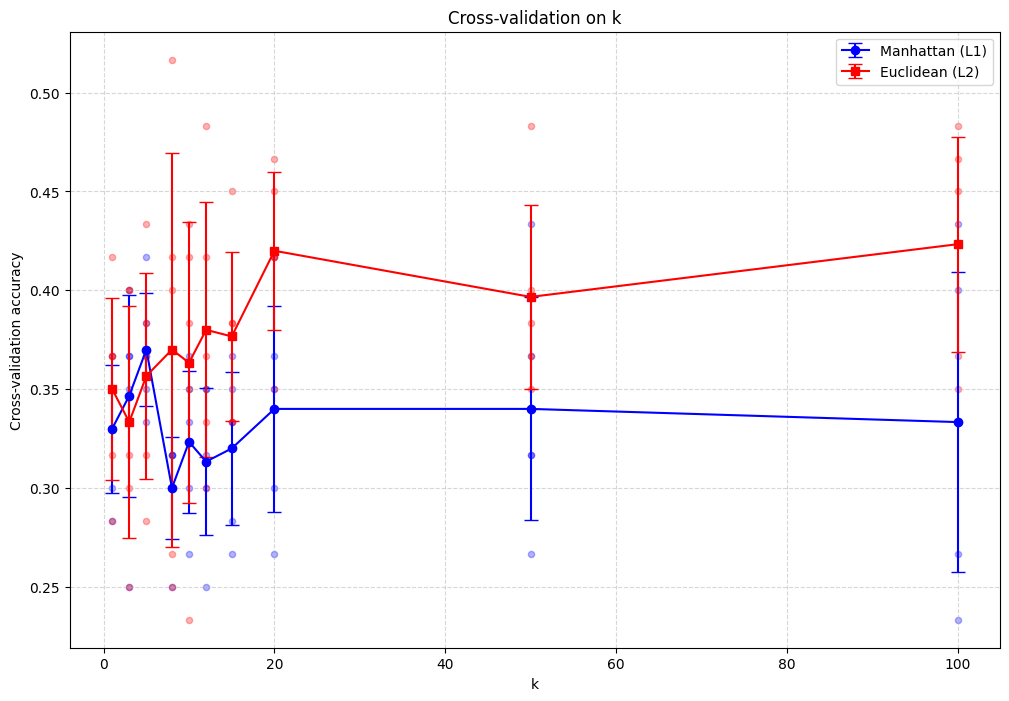

In [5]:
if 'l1_all_accuracies' in locals():
    # Calculate means and standard deviations
    l1_means = [np.mean(acc) for acc in l1_all_accuracies]
    l1_stds = [np.std(acc) for acc in l1_all_accuracies]

    l2_means = [np.mean(acc) for acc in l2_all_accuracies]
    l2_stds = [np.std(acc) for acc in l2_all_accuracies]

    plt.figure(figsize=(12, 8))

    # Plot L1 (Manhattan)
    plt.errorbar(k_values, l1_means, yerr=l1_stds, fmt='-o', label='Manhattan (L1)', color='blue', capsize=5)

    # Plot L2 (Euclidean)
    plt.errorbar(k_values, l2_means, yerr=l2_stds, fmt='-s', label='Euclidean (L2)', color='red', capsize=5)

    # Also plot the individual scatter points to show the spread
    for i, k in enumerate(k_values):
        plt.scatter([k] * len(l1_all_accuracies[i]), l1_all_accuracies[i], color='blue', alpha=0.3, s=20)
        plt.scatter([k] * len(l2_all_accuracies[i]), l2_all_accuracies[i], color='red', alpha=0.3, s=20)

    plt.title('Cross-validation on k')
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

## 5. Discussion

### Comparison of Manhattan (L1) and Euclidean (L2) Distances
Based on the average accuracy values obtained from the 5-fold cross-validation, the **Euclidean (L2)** distance metric consistently outperformed the Manhattan (L1) distance. L2 accuracy peaked at approximately **42.7%**, whereas L1 accuracy remained lower, hovering around **33%**. This suggests that for this specific dataset of 32x32 grayscale images, the Euclidean distance provides a better measure of similarity between image vectors than the Manhattan distance.

### Best Value of K
Based on the graph and results, the best performance was observed around **K=12**, achieving an accuracy of **42.67%** with the L2 metric. Lower values of K (e.g., K=1) resulted in lower accuracy, likely due to overfitting to noise in the training data. As K increased, the model generalized better, but accuracy began to drop slightly at very high K values (e.g., K=100), indicating over-smoothing of the decision boundaries.

### Limitations and Potential Improvements
*   **Limitations**: The overall accuracy is relatively low (max ~43%). This is largely because we are using **raw pixel intensities** as features. Raw pixels are highly sensitive to image variations such as rotation, translation, scaling, and lighting conditions. A slight shift in an image can result in a large distance in the feature space.
*   **Improvements**: To enhance classification accuracy, we could:
    1.  **Feature Extraction**: Use techniques like **HOG (Histogram of Oriented Gradients)** or **SIFT** to extract more robust features that are invariant to geometric transformations.
    2.  **Deep Learning**: Employ **Convolutional Neural Networks (CNNs)**, which are capable of learning hierarchical feature representations directly from the images, typically yielding state-of-the-art results.
    3.  **Data Augmentation**: Increase the effective size of the training set by applying random rotations, flips, and shifts to the existing images.

## 6. Top 5 Predictions
Here are 5 random test images and the model's predictions.

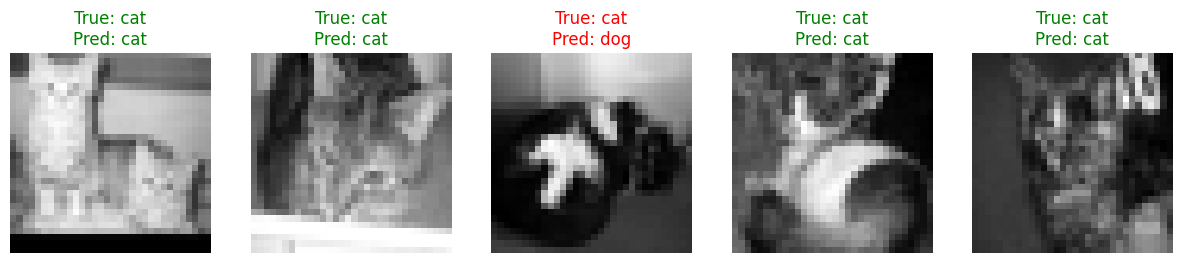

In [6]:
if 'X' in locals():

    split = int(0.8 * len(X))
    X_train_demo, X_test_demo = X[:split], X[split:]
    y_train_demo, y_test_demo = y[:split], y[split:]

    knn_demo = KNN(k=5, metric='l1')
    knn_demo.fit(X_train_demo, y_train_demo)

    if len(X_test_demo) >= 5:
        indices = np.random.choice(len(X_test_demo), 5, replace=False)
        X_sample = X_test_demo[indices]
        y_sample = y_test_demo[indices]

        predictions = knn_demo.predict(X_sample)

        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(1, 5, i+1)

            img = X_sample[i].reshape(32, 32)
            plt.imshow(img, cmap='gray')

            true_label = classes[y_sample[i]]
            pred_label = classes[predictions[i]]

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

        plt.show()